# Pipelines

EvalML pipelines represent a sequence of operations to be applied to data, where each operation is either a data transformation or an ML modeling algorithm.

A pipeline holds a combination of one or more components, which will be applied to new input data in sequence.

Each component and pipeline supports a set of parameters which configure its behavior. The AutoML search process seeks to find the combination of pipeline structure and pipeline parameters which perform the best on the data.

## Defining a Pipeline Instance
Pipeline instances can be instantiated using any of the following classes:

 - `RegressionPipeline`
 - `BinaryClassificationPipeline`
 - `MulticlassClassificationPipeline`
 - `TimeSeriesRegressionPipeline`
 - `TimeSeriesBinaryClassificationPipeline`
 - `TimeSeriesMulticlassClassificationPipeline`
    
The class you want to use will depend on your problem type.
The only required parameter input for instantiating a pipeline instance is `component_graph`, which is either a list or a dictionary containing a sequence of components to be fit and evaluated.

A `component_graph` list is the default representation, which represents a linear order of transforming components with an estimator as the final component. A `component_graph` dictionary is used to represent a non-linear graph of components, where the key is a unique name for each component and the value is a list with the component's class as the first element and any parents of the component as the following element(s). For either `component_graph` format, each component can be provided as a reference to the component class for custom components, and as either a string name or as a reference to the component class for components defined in EvalML.

In [1]:
from evalml.pipelines import MulticlassClassificationPipeline

component_graph_as_list = ['Imputer', 'Random Forest Classifier']
MulticlassClassificationPipeline(component_graph=component_graph_as_list)

pipeline = MulticlassClassificationPipeline(component_graph=['Imputer', 'Random Forest Classifier'], parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}},   random_seed=0)

In [2]:
component_graph_as_dict = {
    'Imputer': ['Imputer'],
    'Encoder': ['One Hot Encoder', 'Imputer'],
    'Random Forest Clf': ['Random Forest Classifier', 'Encoder'],
    'Elastic Net Clf': ['Elastic Net Classifier', 'Encoder'],
    'Final Estimator': ['Logistic Regression Classifier', 'Random Forest Clf', 'Elastic Net Clf']
}

MulticlassClassificationPipeline(component_graph=component_graph_as_dict)

pipeline = MulticlassClassificationPipeline(component_graph=['Imputer', 'Encoder', 'Random Forest Clf', 'Elastic Net Clf', 'Final Estimator'], parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': 'if_binary', 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'Random Forest Clf':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}, 'Elastic Net Clf':{'alpha': 0.5, 'l1_ratio': 0.5, 'n_jobs': -1, 'max_iter': 1000, 'penalty': 'elasticnet', 'loss': 'log'}, 'Final Estimator':{'penalty': 'l2', 'C': 1.0, 'n_jobs': -1, 'multi_class': 'auto', 'solver': 'lbfgs'}},   random_seed=0)

If you're using your own [custom components](components.ipynb) you can refer to them like so:

In [3]:
from evalml.pipelines.components import Transformer

class NewTransformer(Transformer):
    name = 'New Transformer'
    hyperparameter_ranges = {
        "parameter_1":['a', 'b', 'c']
    }
    
    def __init__(self, parameter_1=1, random_seed=0):
        parameters = {"parameter_1": parameter_1}
        super().__init__(parameters=parameters,
                         random_seed=random_seed)
    
MulticlassClassificationPipeline([NewTransformer, 'Random Forest Classifier'])

pipeline = MulticlassClassificationPipeline(component_graph=[NewTransformer, 'Random Forest Classifier'], parameters={'New Transformer':{'parameter_1': 1}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}},   random_seed=0)

## Pipeline Usage

All pipelines define the following methods:

* `fit` fits each component on the provided training data, in order.

* `predict` computes the predictions of the component graph on the provided data.

* `score` computes the value of [an objective](objectives.ipynb) on the provided data.

In [4]:
from evalml.demos import load_wine
X, y = load_wine()

pipeline = MulticlassClassificationPipeline(['Imputer', 'Random Forest Classifier'])
pipeline.fit(X, y)
print(pipeline.predict(X))
print(pipeline.score(X, y, objectives=['log loss multiclass']))

<DataColumn: None (Physical Type = category) (Logical Type = Categorical) (Semantic Tags = {'category'})>
OrderedDict([('Log Loss Multiclass', 0.04132737017536148)])


## Custom Name

By default, a pipeline's name is created using the component graph that makes up the pipeline. E.g. A pipeline with an imputer, one-hot encoder, and logistic regression classifier will have the name 'Logistic Regression Classifier w/ Imputer + One Hot Encoder'.

If you'd like to override the pipeline's name attribute, you can set the `custom_name` parameter when initalizing a pipeline, like so:

In [5]:
component_graph = ['Imputer', 'One Hot Encoder', 'Logistic Regression Classifier']
pipeline = MulticlassClassificationPipeline(component_graph)
print("Pipeline with default name:", pipeline.name)


pipeline_with_name = MulticlassClassificationPipeline(component_graph, custom_name="My cool custom pipeline")
print("Pipeline with custom name:", pipeline_with_name.name)

Pipeline with default name: Logistic Regression Classifier w/ Imputer + One Hot Encoder
Pipeline with custom name: My cool custom pipeline


## Override Component Hyperparameter Ranges

To specify custom hyperparameter ranges, set the `custom_hyperparameters` parameter to be a dictionary where each key-value pair consists of a parameter name and range. AutoML will use this dictionary to override the hyperparameter ranges collected from each component in the component graph.

If the hyperparameter ranges are categorical values, they can be passed in as `skopt.space.Categorical` values.

In [6]:
from skopt.space import Categorical

component_graph = ['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier']
custom_hyperparameters = {
    'Imputer' : {
        'numeric_impute_strategy': Categorical(['most_frequent'])
    }
}

print("Without custom hyperparameters:")
print(MulticlassClassificationPipeline(component_graph=component_graph).hyperparameters)
print()
print("With custom hyperparameters:")
print(MulticlassClassificationPipeline(component_graph=component_graph,
                                       custom_hyperparameters=custom_hyperparameters).hyperparameters)

Without custom hyperparameters:
{'Imputer': {'categorical_impute_strategy': ['most_frequent'], 'numeric_impute_strategy': ['mean', 'median', 'most_frequent']}, 'One Hot Encoder': {}, 'Standard Scaler': {}, 'Logistic Regression Classifier': {'penalty': ['l2'], 'C': Real(low=0.01, high=10, prior='uniform', transform='identity')}}

With custom hyperparameters:
{'Imputer': {'categorical_impute_strategy': ['most_frequent'], 'numeric_impute_strategy': Categorical(categories=('most_frequent',), prior=None)}, 'One Hot Encoder': {}, 'Standard Scaler': {}, 'Logistic Regression Classifier': {'penalty': ['l2'], 'C': Real(low=0.01, high=10, prior='uniform', transform='identity')}}


## Pipeline Parameters

You can also pass in custom parameters by using the `parameters` parameter, which will then be used when instantiating each component in `component_graph`. The parameters dictionary needs to be in the format of a two-layered dictionary where the key-value pairs are the component name and corresponding component parameters dictionary. The component parameters dictionary consists of (parameter name, parameter values) key-value pairs.

An example will be shown below. The API reference for component parameters can also be found [here](../api_reference.rst#components).

In [7]:
parameters = {
        'Imputer': {
            "categorical_impute_strategy": "most_frequent",
            "numeric_impute_strategy": "median"
        },
        'Logistic Regression Classifier': {
            'penalty': 'l2',
            'C': 1.0,
        }
    }
component_graph = ['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier']
MulticlassClassificationPipeline(component_graph=component_graph, parameters=parameters)

pipeline = MulticlassClassificationPipeline(component_graph=['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier'], parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'median', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'One Hot Encoder':{'top_n': 10, 'features_to_encode': None, 'categories': None, 'drop': 'if_binary', 'handle_unknown': 'ignore', 'handle_missing': 'error'}, 'Logistic Regression Classifier':{'penalty': 'l2', 'C': 1.0, 'n_jobs': -1, 'multi_class': 'auto', 'solver': 'lbfgs'}},   random_seed=0)

## Pipeline Description

You can call `.graph()` to see each component and its parameters. Each component takes in data and feeds it to the next.

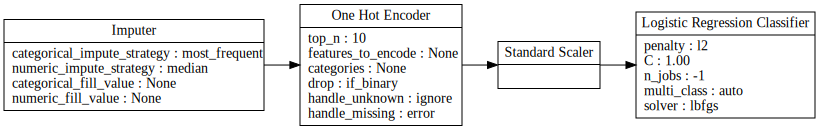

In [8]:
component_graph = ['Imputer', 'One Hot Encoder', 'Standard Scaler', 'Logistic Regression Classifier']
pipeline = MulticlassClassificationPipeline(component_graph=component_graph, parameters=parameters)
pipeline.graph()

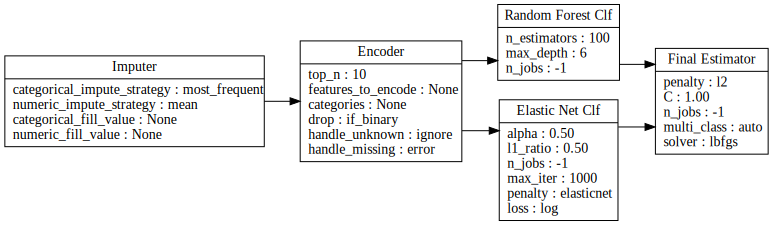

In [9]:
component_graph_as_dict = {
    'Imputer': ['Imputer'],
    'Encoder': ['One Hot Encoder', 'Imputer'],
    'Random Forest Clf': ['Random Forest Classifier', 'Encoder'],
    'Elastic Net Clf': ['Elastic Net Classifier', 'Encoder'],
    'Final Estimator': ['Logistic Regression Classifier', 'Random Forest Clf', 'Elastic Net Clf']
}

nonlinear_pipeline = MulticlassClassificationPipeline(component_graph=component_graph_as_dict)
nonlinear_pipeline.graph()

You can see a textual representation of the pipeline by calling `.describe()`:

In [10]:
pipeline.describe()


*********************************************************************************
* Logistic Regression Classifier w/ Imputer + One Hot Encoder + Standard Scaler *
*********************************************************************************

Problem Type: multiclass
Model Family: Linear

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : median
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : if_binary
	 * handle_unknown : ignore
	 * handle_missing : error
3. Standard Scaler
4. Logistic Regression Classifier
	 * penalty : l2
	 * C : 1.0
	 * n_jobs : -1
	 * multi_class : auto
	 * solver : lbfgs


In [11]:
nonlinear_pipeline.describe()


*******************************************************************************************************************
* Logistic Regression Classifier w/ Imputer + One Hot Encoder + Random Forest Classifier + Elastic Net Classifier *
*******************************************************************************************************************

Problem Type: multiclass
Model Family: Linear

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : if_binary
	 * handle_unknown : ignore
	 * handle_missing : error
3. Elastic Net Classifier
	 * alpha : 0.5
	 * l1_ratio : 0.5
	 * n_jobs : -1
	 * max_iter : 1000
	 * penalty : elasticnet
	 * loss : log
4. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1
5. Logistic Regression Classifier
	 * penalty 

## Component Graph

You can use `pipeline.get_component(name)` and provide the component name to access any component (API reference [here](../generated/methods/evalml.pipelines.PipelineBase.get_component.ipynb)):

In [12]:
pipeline.get_component('Imputer')

Imputer(categorical_impute_strategy='most_frequent', numeric_impute_strategy='median', categorical_fill_value=None, numeric_fill_value=None)

In [13]:
nonlinear_pipeline.get_component('Elastic Net Clf')

ElasticNetClassifier(alpha=0.5, l1_ratio=0.5, n_jobs=-1, max_iter=1000, penalty='elasticnet', loss='log')

Alternatively, you can index directly into the pipeline to get a component

In [14]:
first_component = pipeline[0]
print(first_component.name)

Imputer


In [15]:
nonlinear_pipeline['Final Estimator']

LogisticRegressionClassifier(penalty='l2', C=1.0, n_jobs=-1, multi_class='auto', solver='lbfgs')

## Pipeline Estimator

EvalML enforces that the last component of a linear pipeline is an estimator. You can access this estimator directly by using `pipeline.estimator`.

In [16]:
pipeline.estimator

LogisticRegressionClassifier(penalty='l2', C=1.0, n_jobs=-1, multi_class='auto', solver='lbfgs')

## Input Feature Names

After a pipeline is fitted, you can access a pipeline's `input_feature_names` attribute to obtain a dictionary containing a list of feature names passed to each component of the pipeline. This could be especially useful for debugging where a feature might have been dropped or detecting unexpected behavior.

In [17]:
pipeline = MulticlassClassificationPipeline(['Imputer', 'Random Forest Classifier'])
pipeline.fit(X, y)
pipeline.input_feature_names

{'Imputer': ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline'],
 'Random Forest Classifier': ['alcohol',
  'malic_acid',
  'ash',
  'alcalinity_of_ash',
  'magnesium',
  'total_phenols',
  'flavanoids',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity',
  'hue',
  'od280/od315_of_diluted_wines',
  'proline']}

## Saving and Loading Pipelines

You can save and load trained or untrained pipeline instances using the Python [pickle](https://docs.python.org/3/library/pickle.html#:~:text=%E2%80%9CPickling%E2%80%9D%20is%20the%20process%20whereby,back%20into%20an%20object%20hierarchy.) format, like so:

In [18]:
import pickle

pipeline_to_pickle = MulticlassClassificationPipeline(['Imputer', 'Random Forest Classifier'])

with open("pipeline.pkl", 'wb') as f:
    pickle.dump(pipeline_to_pickle, f)

pickled_pipeline = None
with open('pipeline.pkl', 'rb') as f:
    pickled_pipeline = pickle.load(f)

assert pickled_pipeline == pipeline_to_pickle
pickled_pipeline.fit(X, y)

pipeline = MulticlassClassificationPipeline(component_graph=['Imputer', 'Random Forest Classifier'], parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}},   random_seed=0)

## Generate Code

Once you have a pipeline defined in EvalML, you can generate string Python code to recreate this pipeline, which can then be saved and run elsewhere with EvalML. `generate_pipeline_code` requires a pipeline instance as the input. It can also handle custom components, but it won't return the code required to define the component.

Note that code generation is not yet supported for nonlinear pipelines.

In [19]:
from evalml.pipelines.utils import generate_pipeline_code
from evalml.pipelines import MulticlassClassificationPipeline
import pandas as pd
from evalml.utils import infer_feature_types, _convert_woodwork_types_wrapper

class MyDropNullColumns(Transformer):
    """Transformer to drop features whose percentage of NaN values exceeds a specified threshold"""
    name = "My Drop Null Columns Transformer"
    hyperparameter_ranges = {}

    def __init__(self, pct_null_threshold=1.0, random_seed=0, **kwargs):
        """Initalizes an transformer to drop features whose percentage of NaN values exceeds a specified threshold.

        Arguments:
            pct_null_threshold(float): The percentage of NaN values in an input feature to drop.
                Must be a value between [0, 1] inclusive. If equal to 0.0, will drop columns with any null values.
                If equal to 1.0, will drop columns with all null values. Defaults to 0.95.
        """
        if pct_null_threshold < 0 or pct_null_threshold > 1:
            raise ValueError("pct_null_threshold must be a float between 0 and 1, inclusive.")
        parameters = {"pct_null_threshold": pct_null_threshold}
        parameters.update(kwargs)

        self._cols_to_drop = None
        super().__init__(parameters=parameters,
                         component_obj=None,
                         random_seed=random_seed)

    def fit(self, X, y=None):
        pct_null_threshold = self.parameters["pct_null_threshold"]
        X = infer_feature_types(X)
        X = _convert_woodwork_types_wrapper(X.to_dataframe())
        percent_null = X.isnull().mean()
        if pct_null_threshold == 0.0:
            null_cols = percent_null[percent_null > 0]
        else:
            null_cols = percent_null[percent_null >= pct_null_threshold]
        self._cols_to_drop = list(null_cols.index)
        return self

    def transform(self, X, y=None):
        """Transforms data X by dropping columns that exceed the threshold of null values.
        Arguments:
            X (pd.DataFrame): Data to transform
            y (pd.Series, optional): Targets
        Returns:
            pd.DataFrame: Transformed X
        """

        X = infer_feature_types(X)
        return X.drop(columns=self._cols_to_drop)


pipeline_instance = MulticlassClassificationPipeline(['Imputer', MyDropNullColumns, 'DateTime Featurization Component', 'One Hot Encoder', 'Random Forest Classifier'],
                                                     custom_name="heyo",
                                                     custom_hyperparameters={
                                                         "Imputer": {
                                                             "numeric_impute_strategy": ['mean', 'median']
                                                         }
                                                     },
                                                     random_seed=20)

code = generate_pipeline_code(pipeline_instance)
print(code)

# This string can then be pasted into a separate window and run, although since the pipeline has custom component `MyDropNullColumns`, 
#      the code for that component must also be included
from evalml.demos import load_fraud
X, y = load_fraud()
exec(code)
pipeline.fit(X, y)